# INSY662 - Group Project - Predicting Airline Fares

### Problem Definition and Motivation



### Dataset Description 


### Initial Processing Steps

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re

# Load dataset in folder Data 
df = pd.read_csv('data/processed_data.csv')
df.head()

# keep only 20% of rows 
data = df.sample(frac=0.05, random_state=42)




In [3]:
# 1) Check data types 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205347 entries, 1042959 to 1887118
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              205347 non-null  object 
 1   searchDate                         205347 non-null  object 
 2   flightDate                         205347 non-null  object 
 3   startingAirport                    205347 non-null  object 
 4   destinationAirport                 205347 non-null  object 
 5   fareBasisCode                      205347 non-null  object 
 6   travelDuration                     205347 non-null  object 
 7   elapsedDays                        205347 non-null  int64  
 8   isBasicEconomy                     205347 non-null  bool   
 9   isRefundable                       205347 non-null  bool   
 10  isNonStop                          205347 non-null  bool   
 11  baseFare                           20

In [4]:
# Chekck missing values
data.isnull().sum()

legId                                    0
searchDate                               0
flightDate                               0
startingAirport                          0
destinationAirport                       0
fareBasisCode                            0
travelDuration                           0
elapsedDays                              0
isBasicEconomy                           0
isRefundable                             0
isNonStop                                0
baseFare                                 0
totalFare                                0
seatsRemaining                           0
totalTravelDistance                  15255
segmentsDepartureTimeEpochSeconds        0
segmentsDepartureTimeRaw                 0
segmentsArrivalTimeEpochSeconds          0
segmentsArrivalTimeRaw                   0
segmentsArrivalAirportCode               0
segmentsDepartureAirportCode             0
segmentsAirlineName                      0
segmentsAirlineCode                      0
segmentsEqu

In [5]:
# Missing value Ration
missing_ratio = data.isnull().sum() / len(data) * 100
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)
missing_ratio

totalTravelDistance             7.428889
segmentsEquipmentDescription    1.905555
segmentsDistance                1.023633
dtype: float64

In [6]:
# ---------- Find dupplicates ----------------
dupplicates = data[data.duplicated()]
ratio = len(dupplicates) / len(data) * 100
print(f"There are {len(dupplicates)} out of {len(data)} rows, representing {ratio:.2f}%")

# Ratio is low, drop
data = data.drop_duplicates()
dupplicates = data[data.duplicated()]
ratio = len(dupplicates) / len(data) * 100
print(f"There are {len(dupplicates)} out of {len(data)} rows, representing {ratio:.2f}%")


There are 256 out of 205347 rows, representing 0.12%
There are 0 out of 205091 rows, representing 0.00%


#### Data Cleaning

In [7]:
# ------Drop unecessary segment columns---------
# Reasons: redundent information or not relevant to objective of analysis
unecessary_col = ['segmentsDepartureTimeEpochSeconds', 'segmentsArrivalTimeEpochSeconds', 'segmentsAirlineCode', 'segmentsEquipmentDescription']
data = data.drop(columns = unecessary_col)


In [8]:
# ------------- Clean/Split Segment Columns ---------------

# List segment columns
segments = [col for col in data.columns if "segment" in col.lower()]
segments

# Split columns per segment and drop original column
for col in segments:
    split_cols = data[col].str.split("||", expand=True, regex=False)
    split_cols = split_cols.dropna(axis = 1, how = "all")
    split_cols.columns = [f"{col}_{i+1}" for i in range(split_cols.shape[1])]
    data = pd.concat([data, split_cols], axis = 1)
    data = data.drop(columns = [col])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205091 entries, 1042959 to 1887118
Data columns (total 55 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   legId                           205091 non-null  object 
 1   searchDate                      205091 non-null  object 
 2   flightDate                      205091 non-null  object 
 3   startingAirport                 205091 non-null  object 
 4   destinationAirport              205091 non-null  object 
 5   fareBasisCode                   205091 non-null  object 
 6   travelDuration                  205091 non-null  object 
 7   elapsedDays                     205091 non-null  int64  
 8   isBasicEconomy                  205091 non-null  bool   
 9   isRefundable                    205091 non-null  bool   
 10  isNonStop                       205091 non-null  bool   
 11  baseFare                        205091 non-null  float64
 12  totalFare     

In [10]:
# ------------ Correct Data Types of Segments ----------------

# List segment columns
segmentsTime_cols = [col for col in data.columns if "timeraw" in col.lower()]
for col in segmentsTime_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce', utc=True)
for c in segmentsTime_cols:
    data[c] = data[c].dt.tz_localize(None)

segmentsNumerical_cols = [col for col in data.columns if "seconds" in col.lower() or "distance" in col.lower()]
for col in segmentsNumerical_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')


In [11]:
# ---------Clean Other DataTypes----------------

# Transfrom data columns into correct data types
data['searchDate'] = pd.to_datetime(data['searchDate'])
data['flightDate'] = pd.to_datetime(data['flightDate'])

# Create new column for number of days between search date and flight date
data['date_diff'] = (data['flightDate'] - data['searchDate']).dt.days




In [12]:
#------------- Clean Travel Duration column --------------
def parse_travel_duration(s):
    if pd.isnull(s):
        return None
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', s)
    if not match:
        return None
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    return hours + minutes / 60

data['travelDuration_hours'] = data['travelDuration'].apply(parse_travel_duration)
data = data.drop(columns = 'travelDuration')





In [13]:
data['travelDuration_hours'] 

1042959    17.850000
1437841     2.683333
1067453    10.983333
198386     14.833333
2674967     8.716667
             ...    
2792471     8.066667
39596      12.566667
1117427     5.666667
3329802    15.050000
1887118     8.216667
Name: travelDuration_hours, Length: 205091, dtype: float64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205091 entries, 1042959 to 1887118
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   legId                           205091 non-null  object        
 1   searchDate                      205091 non-null  datetime64[ns]
 2   flightDate                      205091 non-null  datetime64[ns]
 3   startingAirport                 205091 non-null  object        
 4   destinationAirport              205091 non-null  object        
 5   fareBasisCode                   205091 non-null  object        
 6   elapsedDays                     205091 non-null  int64         
 7   isBasicEconomy                  205091 non-null  bool          
 8   isRefundable                    205091 non-null  bool          
 9   isNonStop                       205091 non-null  bool          
 10  baseFare                        205091 non-null  float

In [15]:
data.describe()

,searchDate,flightDate,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw_1,segmentsDepartureTimeRaw_2,segmentsDepartureTimeRaw_3,...,segmentsDurationInSeconds_3,segmentsDurationInSeconds_4,segmentsDurationInSeconds_5,segmentsDistance_1,segmentsDistance_2,segmentsDistance_3,segmentsDistance_4,segmentsDistance_5,date_diff,travelDuration_hours
count,205091,205091,205091.000000,205091.000000,205091.000000,205091.000000,189857.0,205091,149940,19518,...,19518.0,518.0,2.0,189857.0,136807.0,19036.0,518.0,2.0,205091.000000,205021.000000
mean,2022-07-13 21:37:43.254848,2022-08-09 17:48:12.150313472,0.149485,292.735894,340.451497,5.976601,1609.069184,2022-08-10 11:05:12.100872192,2022-08-12 00:56:29.672268800,2022-08-18 03:16:17.715954176,...,7355.699354,6345.289575,6240.0,900.262908,895.418736,641.844085,480.677606,499.5,26.840612,7.132755
min,2022-04-16 00:00:00,2022-04-17 00:00:00,0.000000,0.410000,19.590000,0.000000,89.0,2022-04-17 09:26:00,2022-04-17 12:00:00,2022-04-17 18:15:00,...,1200.0,2880.0,5220.0,67.0,31.0,31.0,90.0,327.0,1.000000,0.766667
25%,2022-06-05 00:00:00,2022-07-01 00:00:00,0.000000,159.000000,197.100000,4.000000,876.0,2022-07-02 00:32:00,2022-07-04 15:58:30,2022-07-14 10:53:45,...,5040.0,5400.0,5730.0,424.0,406.0,338.0,255.0,413.25,13.000000,4.350000
50%,2022-07-16 00:00:00,2022-08-14 00:00:00,0.000000,259.530000,303.700000,7.000000,1464.0,2022-08-15 01:50:00,2022-08-17 12:15:00,2022-08-24 23:50:00,...,6720.0,6330.0,6240.0,720.0,720.0,545.0,549.0,499.5,26.000000,6.816667
75%,2022-08-23 00:00:00,2022-09-18 00:00:00,0.000000,398.140000,452.700000,9.000000,2417.0,2022-09-18 13:45:00,2022-09-20 01:05:00,2022-09-24 22:13:00,...,8100.0,6720.0,6750.0,1193.0,1209.0,720.0,552.0,585.75,40.000000,9.433333
max,2022-10-05 00:00:00,2022-11-19 00:00:00,2.000000,4407.440000,4752.600000,10.000000,4498.0,2022-11-20 05:30:00,2022-11-20 13:16:00,2022-11-20 02:05:00,...,24360.0,19260.0,7260.0,2722.0,2722.0,2722.0,2516.0,672.0,60.000000,23.933333
std,NaN,NaN,0.356608,183.484098,196.363650,2.878256,857.232738,NaN,NaN,NaN,...,3256.59183,1752.200665,1442.497834,646.718788,633.915106,472.82985,282.49481,243.95184,16.314816,3.743439


In [16]:
# Question: Handling Outliers

### Exploratory Data Analysis (EDA) results

In [17]:
# Look at numerical relatioships with Total Fare

import seaborn as sns
import matplotlib.pyplot as plt

def num_plotter(data, target):

    num_cols = data.select_dtypes(include=["int", "float"]).columns

    for col in num_cols:
        if col == target:
            continue  

        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=col, y=target, data=data, alpha=0.3)
        plt.title(f"{col} vs {target}")
        plt.tight_layout()
        plt.show()


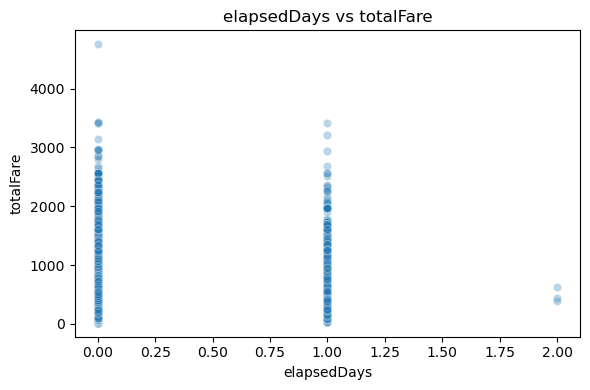

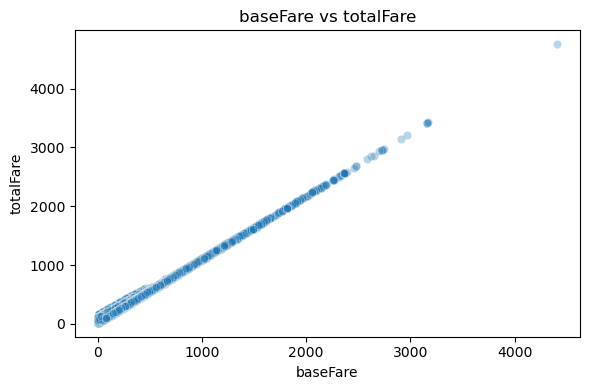

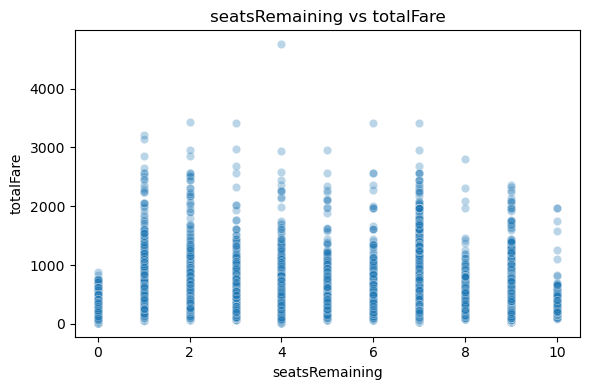

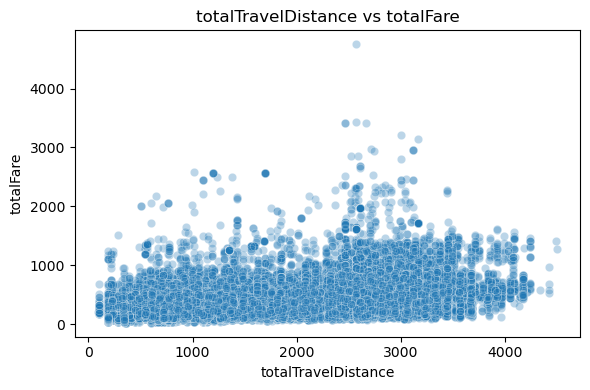

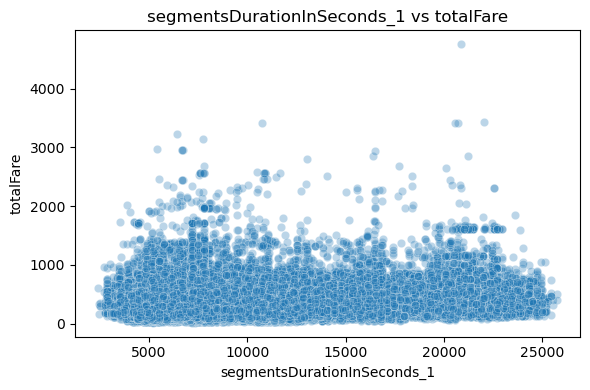

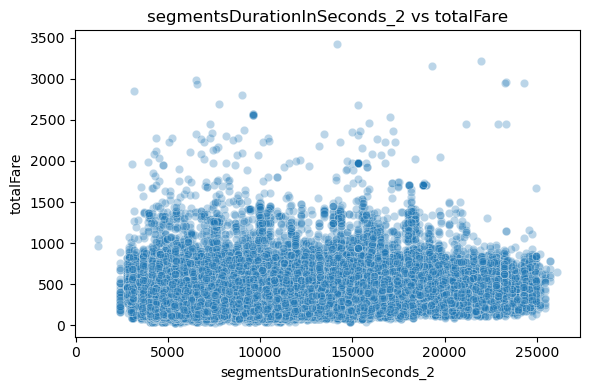

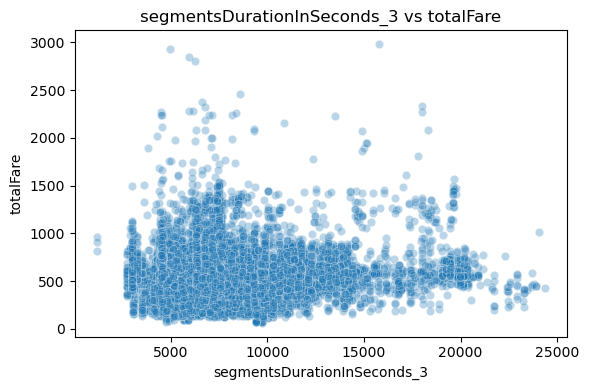

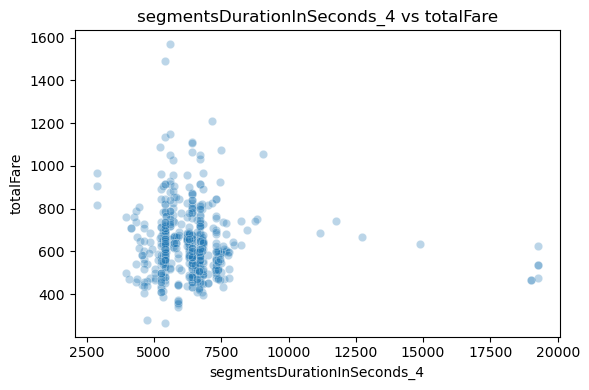

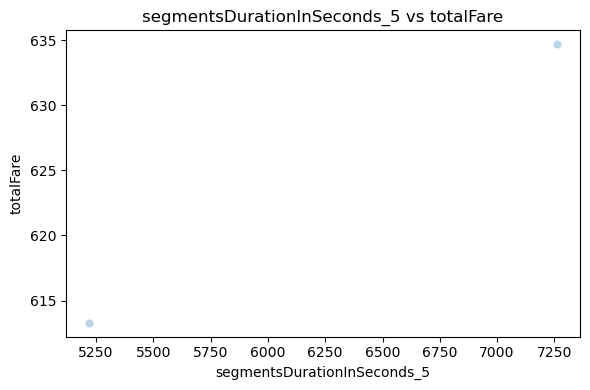

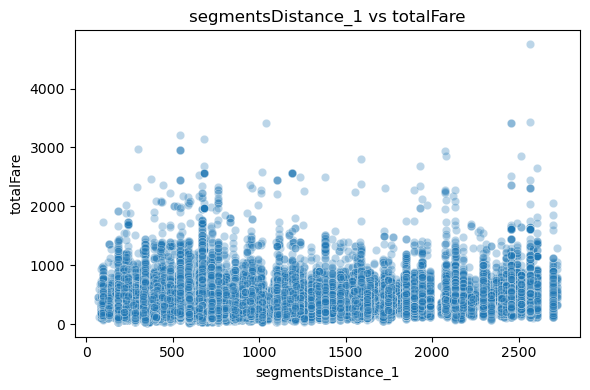

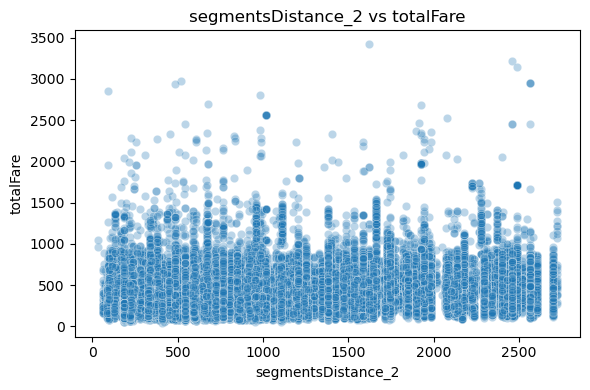

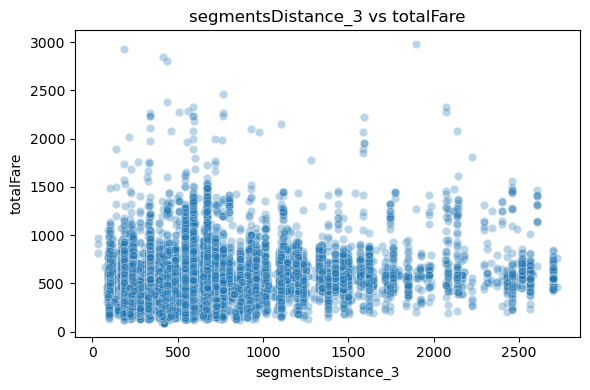

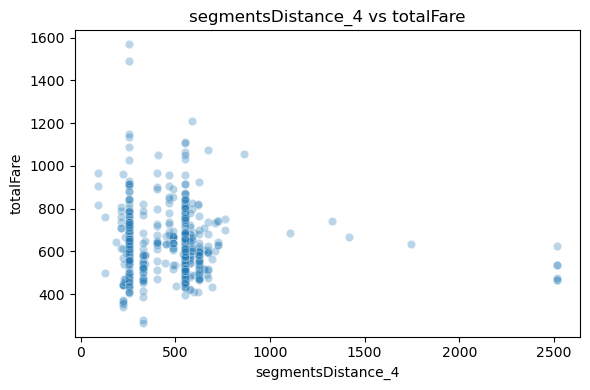

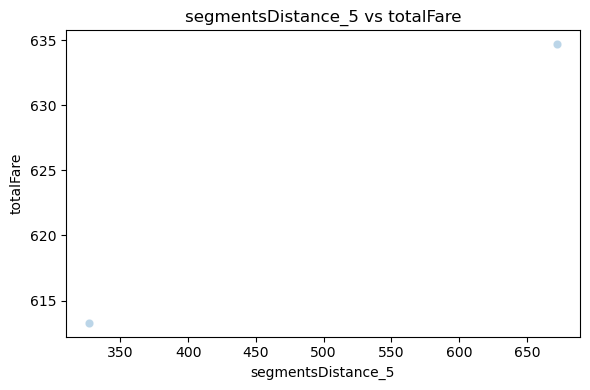

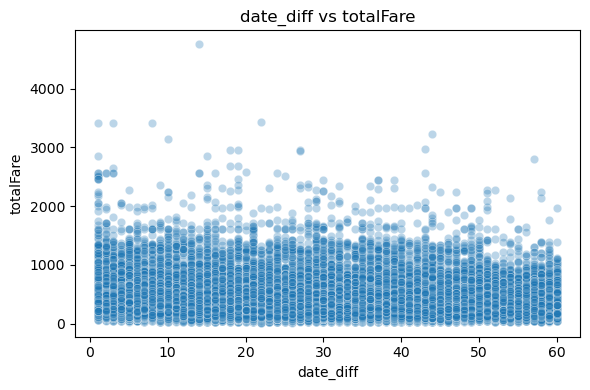

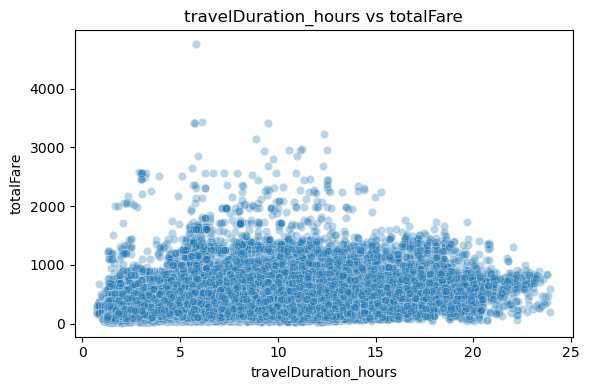

In [18]:
num_plotter(data, "totalFare")


In [19]:
# Look at categorical variable relationships with Total Fare
def cat_plotter(data, target, sample_size=100000):
    cat_cols = [
        'startingAirport',
        'destinationAirport'
    ]
    
    
    # 3. Plot
    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.barplot(
            data=(
                data
                .groupby(col, as_index=False)
                .agg({target: "mean"})
                .sort_values(by=target, ascending=False)
            ), 
            x=col, 
            y=target
        )
        plt.title(f"Average {target} by {col}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    

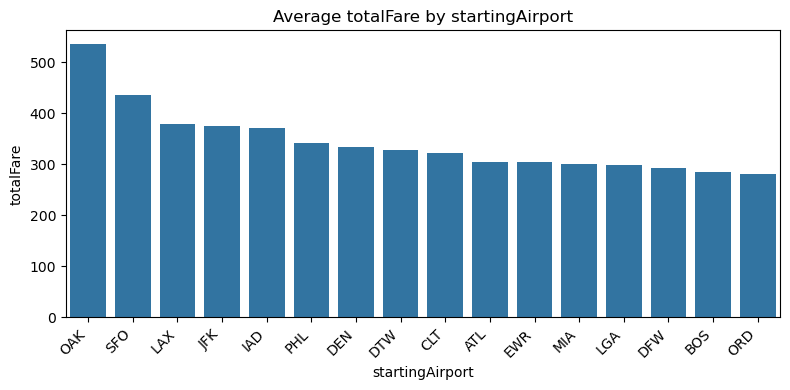

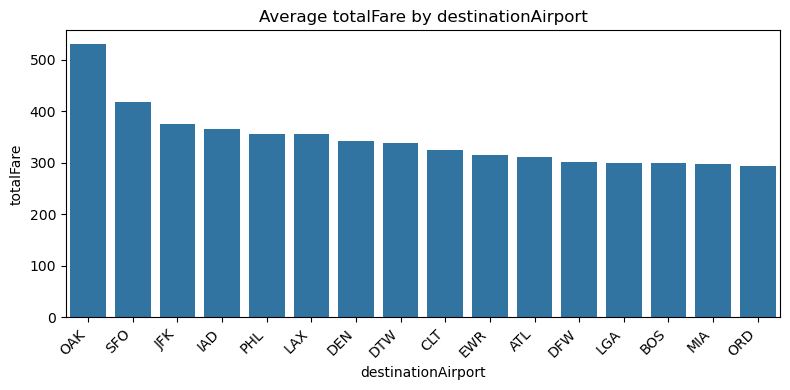

In [20]:
cat_plotter(data, "totalFare", sample_size=100000)


                      elapsedDays  baseFare  totalFare  seatsRemaining  \
elapsedDays              1.000000  0.135252   0.145732       -0.024762   
baseFare                 0.135252  1.000000   0.996711        0.059145   
totalFare                0.145732  0.996711   1.000000        0.020617   
seatsRemaining          -0.024762  0.059145   0.020617        1.000000   
totalTravelDistance      0.294933  0.486401   0.493158       -0.054751   
date_diff                0.005750 -0.059612  -0.058875        0.135607   
travelDuration_hours     0.382040  0.390617   0.427180       -0.149508   

                      totalTravelDistance  date_diff  travelDuration_hours  
elapsedDays                      0.294933   0.005750              0.382040  
baseFare                         0.486401  -0.059612              0.390617  
totalFare                        0.493158  -0.058875              0.427180  
seatsRemaining                  -0.054751   0.135607             -0.149508  
totalTravelDistance   

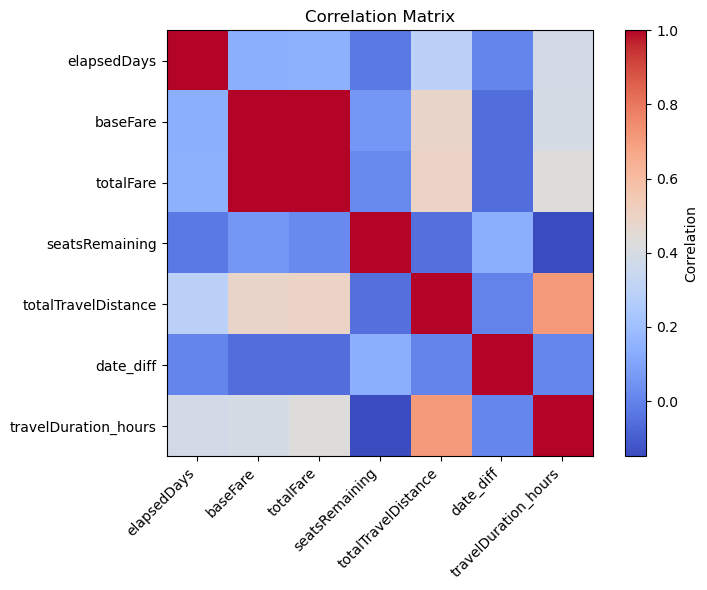

In [21]:
import matplotlib.pyplot as plt
import pandas as pd


# Select only numeric columns
num_df = data.select_dtypes(include=['number'])
# remove segment columns for clarity
num_df = num_df[[col for col in num_df.columns if 'segment' not in col.lower()]]


# Compute correlation matrix
corr = num_df.corr()

# Display top correlations
print(corr)

# Visualize (Matplotlib heatmap only)
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [22]:
data = data.drop(columns = 'baseFare')

### Feature engineering steps

##### Scaling
##### Encoding
##### Binning
##### Transformations
##### Handling Outliers
##### Creation of Derived Variables

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
# ------- Scaling ------

num_col = data.select_dtypes(['int64', 'float64', 'Int64']).columns.tolist()

X = data[num_col]
y = data['totalFare']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 2025)


In [25]:
std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [33]:
# ------- Encoding ---------

cat_cols = [
    'startingAirport', 'destinationAirport',
    'segmentsArrivalAirportCode_1', 'segmentsArrivalAirportCode_2', 
    'segmentsArrivalAirportCode_3', 'segmentsArrivalAirportCode_4', 'segmentsArrivalAirportCode_5',
    'segmentsDepartureAirportCode_1', 'segmentsDepartureAirportCode_2',
    'segmentsDepartureAirportCode_3', 'segmentsDepartureAirportCode_4', 'segmentsDepartureAirportCode_5',
    'segmentsAirlineName_1', 'segmentsAirlineName_2', 'segmentsAirlineName_3', 
    'segmentsAirlineName_4', 'segmentsAirlineName_5',
    'segmentsCabinCode_1', 'segmentsCabinCode_2', 'segmentsCabinCode_3',
    'segmentsCabinCode_4', 'segmentsCabinCode_5'   
]
col_dummy = data[cat_cols]

eng_data = pd.get_dummies(col_dummy, drop_first=True)

eng_data.dtypes


startingAirport_BOS                  bool
startingAirport_CLT                  bool
startingAirport_DEN                  bool
startingAirport_DFW                  bool
startingAirport_DTW                  bool
                                     ... 
segmentsCabinCode_3_coach            bool
segmentsCabinCode_3_first            bool
segmentsCabinCode_3_premium coach    bool
segmentsCabinCode_4_first            bool
segmentsCabinCode_4_premium coach    bool
Length: 722, dtype: object

In [29]:
cat = data.select_dtypes('object').columns.tolist()
cat

['legId',
 'startingAirport',
 'destinationAirport',
 'fareBasisCode',
 'segmentsArrivalAirportCode_1',
 'segmentsArrivalAirportCode_2',
 'segmentsArrivalAirportCode_3',
 'segmentsArrivalAirportCode_4',
 'segmentsArrivalAirportCode_5',
 'segmentsDepartureAirportCode_1',
 'segmentsDepartureAirportCode_2',
 'segmentsDepartureAirportCode_3',
 'segmentsDepartureAirportCode_4',
 'segmentsDepartureAirportCode_5',
 'segmentsAirlineName_1',
 'segmentsAirlineName_2',
 'segmentsAirlineName_3',
 'segmentsAirlineName_4',
 'segmentsAirlineName_5',
 'segmentsCabinCode_1',
 'segmentsCabinCode_2',
 'segmentsCabinCode_3',
 'segmentsCabinCode_4',
 'segmentsCabinCode_5']